In [ ]:
# === 1. 安装依赖库 ===
# 在Colab中运行以下命令安装所需库
!pip install transformers datasets scikit-learn torch



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# === 2. 挂载Google Drive（用于保存模型）===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# === 3. 导入模块 ===
import pandas as pd
from sklearn.model_selection import train_test_split
# === 4. 数据加载与预处理 ===
def load_data(file_path):
    df = pd.read_csv(file_path)
    texts = df['text'].tolist()
    labels = df['Y'].tolist()
    return texts, labels

# 路径配置（请确保文件已上传到Google Drive）
train_file = "/content/drive/MyDrive/Colab Notebooks/sarcasm/sarcasm_train.csv"
test_file = "/content/drive/MyDrive/Colab Notebooks/sarcasm/sarcasm_test.csv"

# 加载数据
train_texts, train_labels = load_data(train_file)
test_texts, test_labels = load_data(test_file)

# 分割训练集/验证集
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_texts, train_labels, test_size=0.2, random_state=42
)

print(f"conjunto de entrenamiento: {len(train_texts)} | conjunto de validación: {len(val_texts)} | conjunto de pruebas: {len(test_texts)}")


conjunto de entrenamiento: 16026 | conjunto de validación: 4007 | conjunto de pruebas: 8586


In [ ]:
import os
import re
import numpy as np

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
import torch
# os.environ['WANDB_API_KEY'] = '255fab36462f5587d825c69b9d5b53a852a2c4d3'  # 替换为你的实际 API 密钥

# === 5. BERT专用预处理 ===
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def preprocess(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)          # 移除URL
    text = re.sub(r'\b(not|no|never)\b\s*', r'\1_', text)  # 处理否定词
    return text.strip()

# 清洗数据
cleaned_train = [preprocess(text) for text in train_texts]
cleaned_val = [preprocess(text) for text in val_texts]
cleaned_test = [preprocess(text) for text in test_texts]

# 转换为Dataset格式
class SarcasmDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(
            texts,
            truncation=True,
            padding=True,
            max_length=128,  # 讽刺文本通常较短
            return_tensors='pt'
        )
        self.labels = labels

    def __getitem__(self, idx):
        item = {k: v[idx] for k, v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SarcasmDataset(cleaned_train, train_labels)
val_dataset = SarcasmDataset(cleaned_val, val_labels)
test_dataset = SarcasmDataset(cleaned_test, test_labels)

# === 6. 模型配置与训练 ===
model_save_path = "/content/drive/MyDrive/Colab Notebooks/sarcasmjuzhen"
os.makedirs(model_save_path, exist_ok=True)

# 加载预训练模型
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    attention_probs_dropout_prob=0.3  # 增加Dropout防止过拟合
).to(device)





/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# 训练参数
training_args = TrainingArguments(
    output_dir=model_save_path,
    eval_strategy="epoch",
    learning_rate=3e-5,          # 更高的学习率
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=5,          # 增加训练轮次
    weight_decay=0.01,
    save_total_limit=3,
    load_best_model_at_end=True, # 根据验证集加载最优模型
    metric_for_best_model="f1",
    logging_dir='./logs',
    logging_steps=50,
    save_strategy="epoch"
)

# 添加早停机制
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=lambda p: {
        "accuracy": (p.predictions.argmax(axis=1) == p.label_ids).mean(),
        "f1": f1_score(p.label_ids, p.predictions.argmax(axis=1))
    },
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)] # 新增早停机制
)

# 执行训练
trainer.train()

# 保存最佳模型
trainer.save_model(model_save_path)
tokenizer.save_pretrained(model_save_path)

# === 7. 模型评估 ===
predictions = trainer.predict(test_dataset)
bert_preds = np.argmax(predictions.predictions, axis=1)

# 计算指标
accuracy = accuracy_score(test_labels, bert_preds)
precision = precision_score(test_labels, bert_preds)
recall = recall_score(test_labels, bert_preds)
f1 = f1_score(test_labels, bert_preds)

print(f"\nBERT Results for Sarcasm Detection:")
print(f"Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1-Score: {f1:.4f}")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anna953480 (anna953480-da) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.288100,0.252779,0.894684,0.882123
2,0.171900,0.249248,0.906663,0.898093
3,0.076300,0.399771,0.899925,0.886499
4,0.050100,0.419733,0.918143,0.910383
5,0.033000,0.449988,0.918642,0.911365



BERT Results for Sarcasm Detection:
Accuracy: 0.9167 | Precision: 0.9322 | Recall: 0.8895 | F1-Score: 0.9103


In [ ]:
# === 8. 错误案例分析 ===
errors = []
for i in range(len(test_labels)):
    if bert_preds[i] != test_labels[i]:
        errors.append({
            'Text': test_texts[i],
            'Cleaned Text': cleaned_test[i],
            'True': test_labels[i],
            'Predicted': bert_preds[i],
            'Logits': predictions.predictions[i].tolist()
        })

print(f"\nNúmero total de errores: {len(errors)} (tasa de error: {len(errors)/len(test_labels):.2%})")
print("Ejemplos de errores críticos:")
for idx, err in enumerate(errors[:5], 1):
    print(f"\nCaso {idx}:")
    print(f"Etiqueta real: {err['True']}, Predicción: {err['Predicted']}")
    print(f"Texto original: {err['Text'][:100]!r}")
    print(f"Texto procesado: {err['Cleaned Text'][:100]!r}")
    print(f"Logits: {err['Logits']}")


Número total de errores: 715 (tasa de error: 8.33%)
Ejemplos de errores críticos:

Caso 1:
Etiqueta real: 1, Predicción: 0
Texto original: 'raytheon ceo sends obama another article about mounting unrest in libya'
Texto procesado: 'raytheon ceo sends obama another article about mounting unrest in libya'
Logits: [3.761169195175171, -4.7898478507995605]

Caso 2:
Etiqueta real: 1, Predicción: 0
Texto original: ' ncis to cease print edition'
Texto procesado: 'ncis to cease print edition'
Logits: [0.917045533657074, -1.2498410940170288]

Caso 3:
Etiqueta real: 0, Predicción: 1
Texto original: 'paula abdul back at it'
Texto procesado: 'paula abdul back at it'
Logits: [-3.1367900371551514, 3.8319923877716064]

Caso 4:
Etiqueta real: 1, Predicción: 0
Texto original: 'powerball super fans camping out before the big drawing dressed up as their favorite numbers'
Texto procesado: 'powerball super fans camping out before the big drawing dressed up as their favorite numbers'
Logits: [3.3046572208404


Matriz de confusión (BERT en Sarcasmo):
[[4242  264]
 [ 451 3629]]


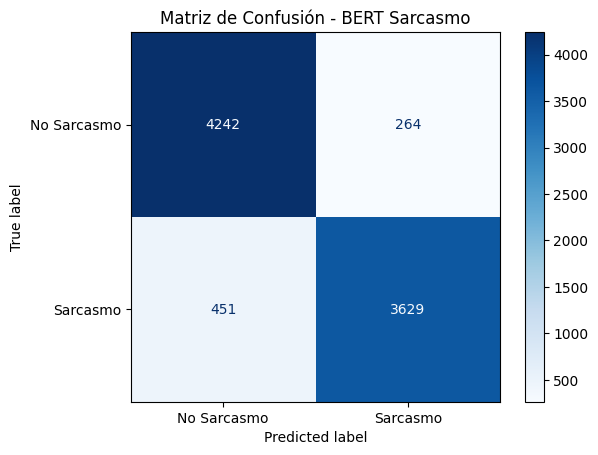

In [ ]:
# === 9. 混淆矩阵分析（新增） ===

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 计算混淆矩阵
cm_sarcasmo = confusion_matrix(test_labels, bert_preds)

# 打印混淆矩阵数据
print("\nMatriz de confusión (BERT en Sarcasmo):")
print(cm_sarcasmo)

# 可视化混淆矩阵
disp = ConfusionMatrixDisplay(confusion_matrix=cm_sarcasmo, display_labels=['No Sarcasmo', 'Sarcasmo'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión - BERT Sarcasmo")
plt.show()
